### SparkMLLib - Clustering - K-Means

**Descrição**
    . Algoritmo nao supervisionado
    . Agrupamento de Dados por Similaridade
    . Particiona os dados em um numero 'k' de clusters, sendo que cada observaçao pertence a apenas um cluster
    . A clusterização é feita medindo a distancia entre os pontos de dados e agrupando-os
    . Múltiplas medidas de distância podem ser usadas, como a distância Euclidiana e distancia Manhattan
    
**Vantagens**
    - Veloz
    - Eficiente quando se tem muitas variáveis
    
**Desvantagens**
    - O valor de K precisa ser conhecido
    - O valor inicial de k tem influencia nos clusters
    
**Aplicação**
    - Agrupamento preliminar antes de se aplicar técnicas de classificação
    - Clusterização geográfica

In [48]:
# import dos modulos
import math
import pandas as pd
from pyspark.sql import Row
from pyspark.ml.linalg import Vectors
from pyspark.ml.clustering import KMeans
import matplotlib.pyplot as plot
%matplotlib inline

In [5]:
# Inicando a Spark Session
spSession = SparkSession.builder.master("local").appName("SparkMLLib-Clustering-K-Means").getOrCreate()

In [11]:
# Carregando os dados
carrosRDD = sc.textFile("carros2.csv")

In [12]:
# verificando o numero de registros
carrosRDD.count()

198

In [13]:
carrosRDD.first()

'MAKE,FUELTYPE,ASPIRE,DOORS,BODY,DRIVE,CYLINDERS,HP,RPM,MPG-CITY,MPG-HWY,PRICE'

In [14]:
# Removendo o cabeçalho
header = carrosRDD.first()
carrosRDD2 = carrosRDD.filter(lambda line: header not in line)
carrosRDD2.count()

197

In [15]:
carrosRDD2.take(5)

['subaru,gas,std,two,hatchback,fwd,four,69,4900,31,36,5118',
 'chevrolet,gas,std,two,hatchback,fwd,three,48,5100,47,53,5151',
 'mazda,gas,std,two,hatchback,fwd,four,68,5000,30,31,5195',
 'toyota,gas,std,two,hatchback,fwd,four,62,4800,35,39,5348',
 'mitsubishi,gas,std,two,hatchback,fwd,four,68,5500,37,41,5389']

In [24]:
# Convertendo e limpando os dados
def limpaDados(inputStr):
    
    attList = inputStr.split(",")
    
    doors = 1.0 if attList[3] == "two" else 2.0
    body = 1.0 if attList[4] == "sedan" else 2.0
    
    linhas = Row(DOORS = doors, BODY = float(body), HP = float(attList[7]), RPM = float(attList[8]),
                 MPG = float(attList[9]))
    
    return linhas

In [25]:
# Aplicando a função ao conjunto de dados
carrosRDD3 = carrosRDD2.map(limpaDados)

In [27]:
# Visualizando o resultado
carrosRDD3.persist()
carrosRDD3.take(5)

[Row(BODY=2.0, DOORS=1.0, HP=69.0, MPG=31.0, RPM=4900.0),
 Row(BODY=2.0, DOORS=1.0, HP=48.0, MPG=47.0, RPM=5100.0),
 Row(BODY=2.0, DOORS=1.0, HP=68.0, MPG=30.0, RPM=5000.0),
 Row(BODY=2.0, DOORS=1.0, HP=62.0, MPG=35.0, RPM=4800.0),
 Row(BODY=2.0, DOORS=1.0, HP=68.0, MPG=37.0, RPM=5500.0)]

In [30]:
# Criando o dataframe
carrosDF = spSession.createDataFrame(carrosRDD3)
carrosDF.show()

+----+-----+----+----+------+
|BODY|DOORS|  HP| MPG|   RPM|
+----+-----+----+----+------+
| 2.0|  1.0|69.0|31.0|4900.0|
| 2.0|  1.0|48.0|47.0|5100.0|
| 2.0|  1.0|68.0|30.0|5000.0|
| 2.0|  1.0|62.0|35.0|4800.0|
| 2.0|  1.0|68.0|37.0|5500.0|
| 2.0|  1.0|60.0|38.0|5500.0|
| 1.0|  1.0|69.0|31.0|5200.0|
| 2.0|  1.0|68.0|37.0|5500.0|
| 2.0|  1.0|68.0|37.0|5500.0|
| 2.0|  1.0|68.0|31.0|5000.0|
| 2.0|  1.0|68.0|31.0|5500.0|
| 2.0|  2.0|68.0|31.0|5500.0|
| 2.0|  2.0|68.0|31.0|5500.0|
| 2.0|  1.0|70.0|38.0|5400.0|
| 2.0|  1.0|62.0|31.0|4800.0|
| 2.0|  1.0|68.0|31.0|5500.0|
| 2.0|  1.0|58.0|49.0|4800.0|
| 2.0|  2.0|62.0|31.0|4800.0|
| 2.0|  1.0|76.0|30.0|6000.0|
| 1.0|  2.0|70.0|38.0|5400.0|
+----+-----+----+----+------+
only showing top 20 rows



In [33]:
# Sumarizando os dados e extraindo a média e o desvio padrao
estats = carrosDF.describe().toPandas()
medias = estats.iloc[1, 1:5].values.tolist()
desvios = estats.iloc[2, 1:5].values.tolist()

In [35]:
# Colocando a media e o desvio padrao em variaveis do tipo broadCast
bc_media = sc.broadcast(medias)
bc_desvio = sc.broadcast(desvios)

In [38]:
# Função para centralizar e aplicar escala aos dados. Cada valor será subtraido da media entao divido pelo desvio padrao
def centerAndScale(inRow):
    
    global bc_media
    global bc_desvio
    
    meanArray = bc_media.value
    stdArray = bc_desvio.value
    
    retArray = []
    
    for data in range(len(meanArray)):
        retArray.append( (float(inRow[data]) - float(meanArray[data])) / float(stdArray[data]) )    
    
    return Vectors.dense(retArray)

In [39]:
carrosRDD4 = carrosDF.rdd.map(centerAndScale)
carrosRDD4.take(5)

[DenseVector([0.9337, -1.145, -0.9194, 0.9083]),
 DenseVector([0.9337, -1.145, -1.4773, 3.3936]),
 DenseVector([0.9337, -1.145, -0.9459, 0.753]),
 DenseVector([0.9337, -1.145, -1.1053, 1.5297]),
 DenseVector([0.9337, -1.145, -0.9459, 1.8403])]

In [41]:
# Criando um dataframe
carrosRDD5 = carrosRDD4.map(lambda f: Row(features = f))
carrosDF = spSession.createDataFrame(carrosRDD5)
carrosDF.select("features").show(10)

+--------------------+
|            features|
+--------------------+
|[0.93367168148051...|
|[0.93367168148051...|
|[0.93367168148051...|
|[0.93367168148051...|
|[0.93367168148051...|
|[0.93367168148051...|
|[-1.0656035495158...|
|[0.93367168148051...|
|[0.93367168148051...|
|[0.93367168148051...|
+--------------------+
only showing top 10 rows



In [42]:
# Criando o modelo
kMeans = KMeans(k = 3, seed = 1)
modelo = kMeans.fit(carrosDF)

In [43]:
# Previsoes
previsoes = modelo.transform(carrosDF)
previsoes.show()

+--------------------+----------+
|            features|prediction|
+--------------------+----------+
|[0.93367168148051...|         1|
|[0.93367168148051...|         1|
|[0.93367168148051...|         1|
|[0.93367168148051...|         1|
|[0.93367168148051...|         1|
|[0.93367168148051...|         1|
|[-1.0656035495158...|         0|
|[0.93367168148051...|         1|
|[0.93367168148051...|         1|
|[0.93367168148051...|         1|
|[0.93367168148051...|         1|
|[0.93367168148051...|         1|
|[0.93367168148051...|         1|
|[0.93367168148051...|         1|
|[0.93367168148051...|         1|
|[0.93367168148051...|         1|
|[0.93367168148051...|         1|
|[0.93367168148051...|         1|
|[0.93367168148051...|         1|
|[-1.0656035495158...|         0|
+--------------------+----------+
only showing top 20 rows



In [44]:
def unstripData(instr):
   return (instr["prediction"], instr["features"][0], instr["features"][1], instr["features"][2], instr["features"][3])

In [50]:
carrosRDD6 = previsoes.rdd.map(unstripData)
predList = carrosRDD6.collect()
predPd = pd.DataFrame(predList)

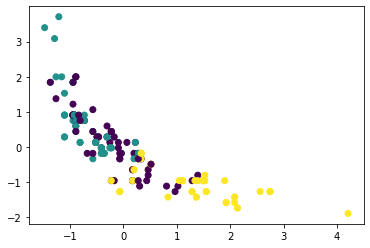

In [52]:
# Grafico com o resultado dos clusters criados
plot.cla()
plot.scatter(predPd[3], predPd[4], c = predPd[0])

### FIM